In [ ]:
# Este exemplo tem como objetivo classificar Gatos e Cachorros,
# Porém além de usar as imagens de treino e teste também utilizarei
# a técnica de aumento de imagem criando imagens artificiais usando
# o imageDataGenerator

In [29]:
# Bibliotecas
import os
import zipfile
import zipfile
import random
import tensorflow as tf

from shutil import copyfile # para copiar arquivos de uma pasta para outra
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [1]:
# Caso fosse necessário baixar iria executar: (vai estar em modo texto pois já foi feito para exercicio anterior)
!pip install wget # para instalar no google colab

import wget

url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip"
filename = wget.download(url)

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=8c086984e01a6f2d75c6bbfb3c149c2a0bc1197f9421ca180cf9de84cfea7c2d
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [20]:
# Caso fosse necessário dezipar:

local_zip = '/content/kagglecatsanddogs_3367a.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r') # abrindo em modo leitura
zip_ref.extractall('temp') # Extraindo
zip_ref.close() # Fechando

In [21]:
# Verificando quantidade de arquivos
print(len(os.listdir('temp/PetImages/Cat')))
print(len(os.listdir('temp/PetImages/Dog')))

12501
12501


In [35]:
# Criando as pasta
try:
    os.mkdir('/content/cats-v-dogs')
    os.mkdir('/content/cats-v-dogs/training')
    os.mkdir('/content/cats-v-dogs/testing')
    os.mkdir('/content/cats-v-dogs/training/cats')
    os.mkdir('/content/cats-v-dogs/training/dogs')
    os.mkdir('/content/cats-v-dogs/testing/cats')
    os.mkdir('/content/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [36]:
# Criando função que fará o split dos dados:

def split_data(source, training, testing, splitsize):
    # Copiando todos os nomes
    file_list = []
    for filename in os.listdir(source):
        file = source + filename
        if os.path.getsize(file) > 0:
            file_list.append(filename)
        else:
            print(filename + ' is zero length, so ignoring.')
    
    # Randomizando e Separando em listas de treino e de teste 
    training_len = int(len(file_list)*splitsize) # qtde de treino
    testing_len = int(len(file_list)-training_len) # qtde de teste
    shuffled_set = random.sample(file_list, len(file_list)) # randomizando todos arquivos
    training_set = shuffled_set[0:training_len]
    testing_set = shuffled_set[training_len:]
    
    # Usando os nomes das imagens, copiar de uma pasta para outra
    for filename in training_set:
        copyfile(source+filename, training+filename)
    for filename in testing_set:
        copyfile(source+filename, testing+filename)


In [37]:
# Mesma pasta que descompactamos
cat_source = '/content/temp/PetImages/Cat/'
dog_source = '/content/temp/PetImages/Dog/'

# Pastas criadas anteriormente
training_cats_dir = 'cats-v-dogs/training/cats/'
training_dogs_dir = 'cats-v-dogs/training/dogs/'
testing_cats_dir = 'cats-v-dogs/testing/cats/'
testing_dogs_dir = 'cats-v-dogs/testing/dogs/'

split_size= .9

split_data(cat_source, training_cats_dir, testing_cats_dir, split_size)
split_data(dog_source, training_dogs_dir, testing_dogs_dir, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [38]:
# Observando os resultados das separações
# os.listdir(path) => Retorna lista de arquivos no diretório
print(len(os.listdir('cats-v-dogs/training/cats')))
print(len(os.listdir('cats-v-dogs/training/dogs')))
print(len(os.listdir('cats-v-dogs/testing/cats')))
print(len(os.listdir('cats-v-dogs/testing/dogs')))

11250
11250
1250
1250


In [60]:
# Criando datagenerator.
# Desta vez vamos passar mais parametros além do "rescale"
# Quanto mais parametros utilizarmos, mais possibilidades de aumento de imagens
# Entretanto o custo computacional aumenta proporcionalmente
# Veremos se passamos dos 80% de acurácia em teste.
# Links uteis: 
# https://cdn-images-1.medium.com/max/1000/1*uwnaDjYuMuYyVK0m-5RcjQ.png
# https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/

training_dir = 'cats-v-dogs/training' 
testing_dir = 'cats-v-dogs/testing'

# Training generator
train_datagen = ImageDataGenerator(
    rescale = 1./255, # rescalando
    rotation_range = 40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest' # como vai preencher quando tiver pixels nulos
)

train_generator = train_datagen.flow_from_directory(
    training_dir,
    batch_size=20,
    class_mode='binary',
    target_size=(150,150)
)

# Training generator
valid_datagen = ImageDataGenerator(
    rescale = 1./255, # rescalando
    rotation_range = 40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest' # como vai preencher quando tiver pixels nulos
)

valid_generator = valid_datagen.flow_from_directory(
    testing_dir,
    batch_size=20,
    class_mode='binary',
    target_size=(150,150)
)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [51]:
# Criando modelo CNN

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [52]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)            

In [59]:
# Indicando função de perda e otimizador
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Ignorando Warnings
import warnings
warnings.filterwarnings("ignore")

# Fitando
history = model.fit(
    train_generator, #carrega os dados (e suas labels)
    steps_per_epoch=100, # 2000 images = batch_size * steps
    epochs=100,
    verbose=1,
    validation_data=valid_generator,
    validation_steps=50 # 1000 images = batch_size * steps
)

Epoch 1/100
100/100 [==============================] - 24s 243ms/step - loss: 0.5020 - accuracy: 0.7613 - val_loss: 0.4758 - val_accuracy: 0.7970
Epoch 2/100
100/100 [==============================] - 24s 244ms/step - loss: 0.5119 - accuracy: 0.7505 - val_loss: 0.5434 - val_accuracy: 0.7590
Epoch 3/100
100/100 [==============================] - 25s 248ms/step - loss: 0.5182 - accuracy: 0.7495 - val_loss: 0.4601 - val_accuracy: 0.8070
Epoch 4/100
100/100 [==============================] - 24s 244ms/step - loss: 0.5271 - accuracy: 0.7535 - val_loss: 0.4989 - val_accuracy: 0.7740
Epoch 5/100
100/100 [==============================] - 25s 245ms/step - loss: 0.4915 - accuracy: 0.7685 - val_loss: 0.5318 - val_accuracy: 0.7790
Epoch 6/100
100/100 [==============================] - 24s 245ms/step - loss: 0.5147 - accuracy: 0.7600 - val_loss: 0.4977 - val_accuracy: 0.7650
Epoch 7/100
100/100 [==============================] - 24s 245ms/step - loss: 0.5015 - accuracy: 0.7640 - val_loss: 0.4478 -

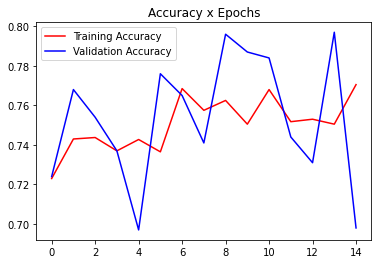

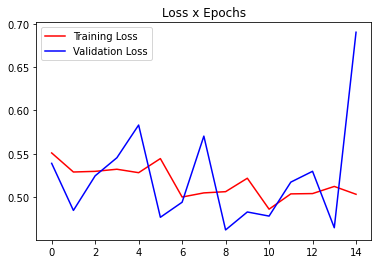

In [62]:
# Definições das plotagens:

import matplotlib.pyplot as plt

# Dados do treino
acc = history.history['accuracy']
loss = history.history['loss']
# Dados da validação
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
# Épocas
epochs = range(len(acc))

# Plots
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.title('Accuracy x Epochs')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Loss x Epochs')
plt.legend()